# Tarea 4
Curso de Física computacional

Joseph Nicolay Ruiz Alvarez




In [144]:
#Importación de librerías para el desarollo de la tarea
import numpy as np
import matplotlib.pyplot as plt
import pandas as pdf
from scipy import constants

from IPython.display import display, Math,  Latex
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Pulse para codigo</button>''', raw=True)



Pulse para codigo

## Introducción 

La zona habitable es una region en la que cualquier planeta rocoso con ciertas condiciones (composicion atmosférica, excentricidad, rotacion, etc.) puede tener agua en estado lıquido sobre su superficie. En general es un proceso complicado determinar si un planeta est ́a en la zona habitable de una estrella, pero para este ejercicio vamos a utilizar un prosedimiento aproximado desarrollad en http://phl.upr.edu/. Donde se calculan los limites interior ($r_i$) y exterior ($r_o$) de la zona de habitabilidad usando la siguientes expresiones:

$$ r_{i} = [r_{is} − a_{i}(T_{eff} − T_{s}) − b_{i}(T_{eff} − T_{s})\sqrt{\mathcal{L}}$$

$$ r_{o} = [r_{os} − a_{o}(T_{eff} − T_{s}) − b_{o}(T_{eff} − T_{s})\sqrt{\mathcal{L}} $$


donde $\mathcal{L} = 4\pi R^{2} \sigma T^{4}$ es la luminosidad estelar en unidades solares, $T_{eff}$ es la temperatura efectiva estelar en unidades $K$, $T_{s} = 5780 K$ la temperatura efectiva del sol y $a_{i} = 2.7619e−5$, $b_{i} = 3.8095e−9$, $a_{o} = 1.3786e−4$, $b_{o} = 1.4286e−9$, $r_{is} = 0. 72$ y $r_{os} = 1. 77$ son constantes. Aquellos planetas que se encuentre entre dichos límites definidos por $[r_{i},r_{o}]$.


## Desarrollo del código

Se obtiene la base de datos de exoplanetas encontrados hasta el momento de http://exoplanets.org/csv-files/exoplanets.csv y se cargan en un marco de datos (Data Frame (DF)).

###  Creacíon de un DF

Se seguiran las siguientes instrucciones en la creación del marco de datos 

-rescalamiento de unidades
-elección de sistemas no binarios
-cálculo de la luminosidad relativa (luminositad solar), límites $r_{i}$, $r_{o}$
-región habitable

In [172]:
#Leemos los datos descargados
df = pd.read_csv('exoplanets.csv')

# Etiquetas
## Para el planeta

NAME = df['NAME']          # Nombre del exoplaneta
TEFF = df['TEFF']          # Temperatura efectiva
MASS = df['MASS']          # Masa del exoplaneta
A = df['A']                # Distancia del exoplaneta desde la estrella [AU]
DENSITY = df['DENSITY']    # Densidad del exoplaneta
R = df['R']                # Radio del exoplaneta

# Para la estrella

STAR = df['STAR']          # Nombre de la estrella
MSTAR = df['MSTAR']        # Masa de la estrella
RSTAR = df['RSTAR']        # Radio de la estrella

# Para identificar si el sistema es o no es binario
BINARY = df['BINARY']  


#Los datos de masa y el radio son jovianos (Jupiter)
#Definimos algunas funciones de conversio a unidades Tierra
#(valores de conversión tomados de Google)

# Conversion de masa joviana a masa terrestre
def EarthMass(x):
    return 317.907*x



# Conversion de radio joviano a radio terrestre
def EarthRadius(x):
    return 11.2089*x

# Hacemos la conversión

# Radio
RE = R.pipe(EarthRadius)

# Masa
MASSE = MASS.pipe(EarthMass)



#Reinventamos el DF con los nuevos ajustes y designaciones

dict = { "NAME": NAME, "TEFF": TEFF, "MASSJ": MASS, "MASSE": MASSE, "A": A, "DENSITY":DENSITY, "RJ":R,"RE":RE ," STAR": STAR, "MSTAR": MSTAR, "RSTAR": RSTAR,"BINARY":BINARY }
df = pd.DataFrame(dict) 

#Algunos valores aparecen como vacíos (NaN) y nulos (0==False)
#df.notnull()
# Así que descartemos los sistemas que presentan estas características, sistemas Binarios
#Es decir, descartamos si BINARY == True (1) & NaN y extraemos los BINARY  == False (0)
df = df.query("BINARY == False")

#Filtramos y seleccionamos los exoplanetas rocosos
df = df.query("DENSITY>=5")  #5 g/cm³

#Visualizar valores no nulos de las columnas
#df.notnull()

# Función para convertir Rad solares a metros
def Rad_sol_to_meters(x):
    return x*6.95700*10**8

# Calculemos ahora la luminosidad relatividad al sol
def Luminosity(Ratio,Temperature):
    
    sigma_b = constants.Stefan_Boltzmann
    pi = constants.pi
    lumin_solar = 3.83e+26
    return (4*pi*Rad_sol_to_meters(Ratio)**2*sigma_b*Temperature**4)/lumin_solar

# Anexamos una columna: Luminosidad relativa de la Estrella
df["LUM"] = Luminosity(df['RSTAR'],df['TEFF'])


#Cálculo de los límites

Ts = 5780         # Temperatura efectiva del sol
a_i = 2.7619e-5   # constante
b_i = 3.8095e-9   # constante
a_o = 1.3786e-4   # constante
b_o = 1.4286e-9   # constante 
r_is = 0.72      # ri sol (intern)
r_os = 1.77      # ro sol (outer)

df["$r_i$"] = (r_is - a_i*(df["TEFF"] - Ts) - b_i*(df["TEFF"] - Ts)**2 )*np.sqrt(df["LUM"])
df["$r_o$"] = (r_os - a_o*(df["TEFF"] - Ts) - b_o*(df["TEFF"] - Ts)**2 )*np.sqrt(df["LUM"])

#Zona habitable HZD (Habitable Zone Distance)
df["HZD"] = (2*df["A"] - df["$r_o$"] - df["$r_i$"])/(df["$r_o$"] - df["$r_i$"])

#Seleccionamos aquellos que cumplan -1<=HZD<=1
df = df.query("HZD<=1 and HZD>=-1")





/home/joshep/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5,10,11,17,18,23,24,26,27,30,33,38,39,44,45,50,51,56,57,62,63,70,71,73,74,79,80,81,82,88,89,95,96,105,106,109,110,115,116,117,124,125,130,131,137,143,144,149,150,159,160,161,162,172,173,174,179,180,182,188,189,195,196,201,202,205,206,211,212,217,218,223,224,229,230,235,236,241,242,247,248,253,254,259,260,265,266,268,269,270,271,273,278,279,284,285,290,291,294,295,301,302,304,305,310,311) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [173]:
#Data Frame resultante
print('Los exoplanetas rocosos (densidad mayor o igual a 5 g/cm³) en la distacia de zona habitable son:')
print('Dimensiones del Data Frame son: ', df.shape)
df



Los exoplanetas rocosos (densidad mayor o igual a 5 g/cm³) en la distacia de zona habitable son:
Dimensiones del Data Frame son:  (3, 16)


,STAR,A,BINARY,DENSITY,MASSE,MASSJ,MSTAR,NAME,RE,RJ,RSTAR,TEFF,LUM,$r_i$,$r_o$,HZD
1566,K2-18,0.142931,0.0,7.8700,8.054810,0.025337,0.359,K2-18 b,2.427556,0.216574,0.411,3457.0,0.021724,0.112549,0.306950,-0.687426
2417,Kepler-22,0.848513,0.0,12.8929,5.828666,0.018335,0.970,Kepler-22 b,2.381891,0.212500,0.979,5518.0,0.800126,0.650277,1.615482,-0.589236
2910,LHS 1140,0.087494,0.0,12.5000,6.748816,0.021229,0.146,LHS 1140 b,1.468489,0.131011,0.186,3131.0,0.002994,0.041936,0.116280,0.225593


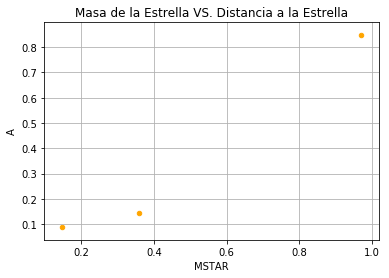

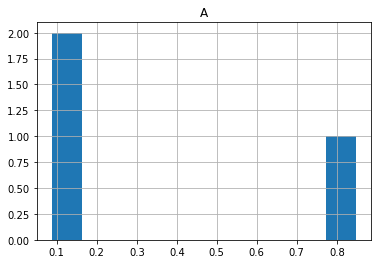

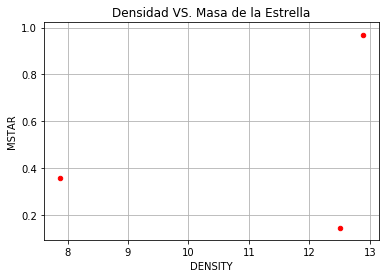

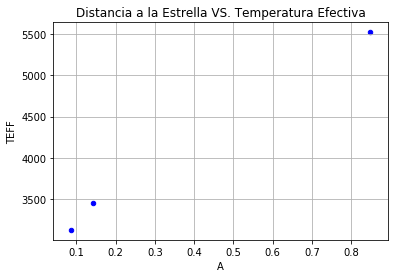

In [186]:
# Gráficas


df.plot.scatter(x='MSTAR',y='A',grid= True, color='orange', title = 'Masa de la Estrella VS. Distancia a la Estrella')
df.hist(column = 'A')
df.plot.scatter(x='DENSITY', y='MSTAR',grid= True,color='red', title = 'Densidad VS. Masa de la Estrella')
df.plot.scatter(x='A', y='TEFF',grid= True,color='blue',title = 'Distancia a la Estrella VS. Temperatura Efectiva')